In [1]:
#%pip install gym[classic_control]

In [2]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import Adam
from pygame import gfxdraw
import os
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
n_episodes = 50
output_dir = "model_output/cartpole/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.batch_size = 32
 
    def _build_model(self):
        model = Sequential() 
        model.add(Dense(32, activation="relu", input_dim=self.state_size))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model
 
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) 
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def save(self, name): 
        self.model.save_weights(name)

In [5]:
agent = DQNAgent(state_size, action_size)

c:\Users\memed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


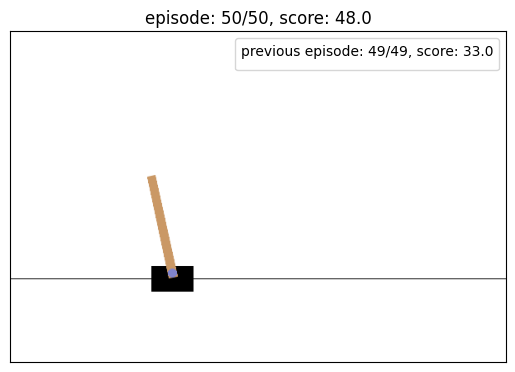

In [6]:
loss = []
agent = DQNAgent(state_size, action_size)
previous_score = 0
for e in range(0, n_episodes+1):
    state = env.reset()
    state = np.reshape(state[0], (1, 4))
    score = 0
    max_steps = 1000
    for i in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, info = env.step(action)
        score += reward
        next_state = np.reshape(next_state, (1, 4))
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        agent.replay()

        clear_output(wait=True)
        plt.imshow(env.render())
        plt.title("episode: {}/{}, score: {}".format(e, n_episodes, score))
        plt.xticks([])
        plt.yticks([])
        plt.legend([],[],title="previous episode: {}/{}, score: {}".format(e-1, n_episodes-1, previous_score))
        plt.show()

        if done:
            previous_score = score
            break
        env.step(action)
    loss.append(score)

Text(0.5, 1.0, 'Cart Pole game Loss through the episodes')

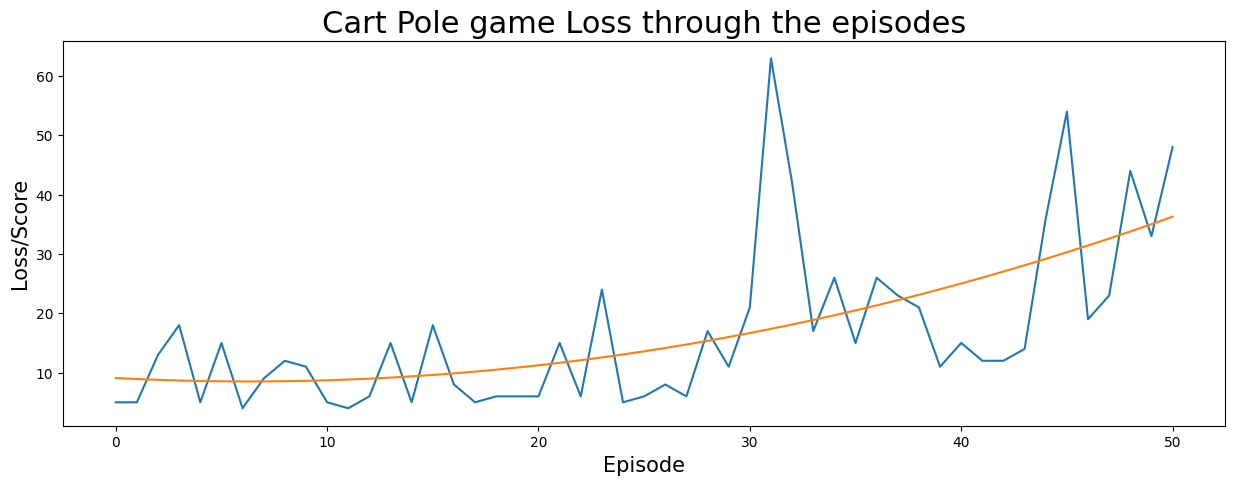

In [10]:
x = np.arange(0,n_episodes+1)
y = loss
a, b, c = np.polyfit(x, y, 2)
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,n_episodes+1), loss)
plt.plot(x, a * x*x + b*x + c)
plt.xlabel('Episode', fontdict={'size' : 15})
plt.ylabel('Loss/Score', fontdict={'size' : 15})
plt.title('Cart Pole game Loss through the episodes', fontdict={'size' : 22})